# Modelling with Stemming

## Contents

The structure will be the similar as Notebook #3 with the addition of Snowball Stemming.

- Snowball Stemming.


- NLP Modelling
    - Models 1-14
    - Model Selection
        - Metric Evaluation        
        - CountVectorizer Vs TfidfVectorizer
        - Conservative Approach (No stemming) vs Aggressive Approach (Snowball Stemming)
        - Hyperparameter
        - Visualizing the results: ROC-AUC Curves

NTLK Tokenizing and Snowball Stemming is used because Snowball Stemmer is a more aggressive form of stemming compared to Porter Stemmer.

The same combinations of Vectorizers and Classifiers are used in Notebook #3, with the purpose of comparing the results with & without stemming.

It has been discovered that the best performing combination is Snowball Stemming + TfidfVectorizer + Logistic Regression with parameters of ____

In [1]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.text import Text
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import gensim
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, roc_auc_score, plot_roc_curve, roc_curve

import warnings
warnings.simplefilter("ignore")

# Preprocessing: Tokenizing & Stemming

In [2]:
combined = pd.read_csv("data/combined.csv")

ss = SnowballStemmer(language = "english")

def stemmer(sentence):
    
    #concatenates words into strings becuase ss.stem accepts strings as input
    
    stemmed = ""
    for word in sentence:
        w = ss.stem(word)
        stemmed += " "
        stemmed += w
    return stemmed

def tokenize_stemmer(df):
    
    df["stemmed"] = df["words"].apply(word_tokenize)
    df["stemmed"] = df["stemmed"].apply(stemmer)
    return df

In [3]:
combined = tokenize_stemmer(combined)
combined.to_csv("data/combined_stemmed.csv")

## Stopwords Filtration - similar to Notebook 3

In [4]:
combined = pd.read_csv("data/combined_stemmed.csv")

In [5]:
additional = ["lamborghini", "lambo", "tesla", "teslas" "elon", "musk", "www", "com", "http", "like", "just", "want", "use", "got", "know",
             "support", "thread", "question", "answer", "deleted", "jpg", "reddit", "redd", "ve", "get", "go", "going",
             "post", "pdf", "jpeg", "png", "default", "amp", "way", "car", "cars", "files", "poll", "vote", "see", "day",
             "please", "help", "make", "made", "look", "long", "time", "still", "don", "take", "from", "back", "wiki", "subreddit",
             "live", "chat", "new", "ive", "really", "need", "dont", "im", "looking", "getting", 
             "easily", "share", "reach", "welcoming", "today", "time", "think", "day", "saw", "just",
             "people", "year", "video", "work", "good", "price", "better", "vs", "buy", "week", "best", "years", "guys", "took"]

sw = STOPWORDS.union(additional)
print(len(sw))

409


In [6]:
x = combined["words"]
y = combined["y"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33,
                                                    stratify = y,
                                                    random_state = 42)

# Modelling

A total of 14 models are tested. Logistic Regression is the model with the highest accuracy without compromising significantly on ROC-AUC.

In [7]:
def fit_gs(clf, params, vectorizer):
    """fits a GridSearchCV to a classifier, prints best params and scores, and returns model"""
    
    pipe = Pipeline([("vectorizer", vectorizer(stop_words = sw, ngram_range = (1,2))), ("classifier", clf)])
    
    gs = GridSearchCV(pipe, params, cv=5, n_jobs=-1, scoring="roc_auc")
    gs.fit(x_train, y_train)
    print(" GridSearchCV ".center(45, "="))
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Best Score (ROC_AUC): {gs.best_score_}")
    print()
    print(" Evaluation ".center(45, "="))
    
    y_train_pred = gs.predict(x_train)
    tn1, fp1, fn1, tp1 = confusion_matrix(y_train, y_train_pred).ravel()
    accuracy = (tn1 + tp1) / (tn1 + fp1 + fn1 + tp1)
    
    print(
        f"Train Score (Accuracy): {accuracy}"
        )
        
        
    y_test_pred = gs.predict(x_test)
    tn2, fp2, fn2, tp2 = confusion_matrix(y_test, y_test_pred).ravel()
    accuracy = (tn2 + tp2) / (tn2 + fp2 + fn2 + tp2)
    
    print(
        f"Testing Score (Accuracy): {accuracy}"
    )

    print(
        f"Train Score (ROC AUC): {roc_auc_score(y_train, gs.predict_proba(x_train)[:,1])}"
    )
    print(
        f"Testing Score (ROC AUC): {roc_auc_score(y_test,gs.predict_proba(x_test)[:,1])}"
    )

    return gs

# Models 1-7: CountVectorizer with Classifiers

### Random Forest Classifier

In [8]:
rfc_params = {
    "classifier__n_estimators": [10, 50, 100, 250],
    "classifier__max_depth": [5, 10, 20],
    "classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}],
    "classifier__random_state": [42],
}

rfc_cv = fit_gs(RandomForestClassifier(), rfc_params, CountVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__n_estimators': 250, 'classifier__random_state': 42}
Best Score (ROC_AUC): 0.9406134076971856

================= Evaluation ================
Train Score (Accuracy): 0.8275294762818756
Testing Score (Accuracy): 0.8024485253199778
Train Score (ROC AUC): 0.9677673781704282
Testing Score (ROC AUC): 0.9421280877143599


### Support Vector Classifier

In [9]:
svc_params = {
    "classifier__C": [10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1, 10 ** 2],
    "classifier__class_weight": [None, {0: 1, 1: 10}, {0: 1, 1: 25}],
    "classifier__probability": [True],
    "classifier__random_state": [42],
}

svc_cv = fit_gs(SVC(), svc_params, CountVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__probability': True, 'classifier__random_state': 42}
Best Score (ROC_AUC): 0.9604838109711171

================= Evaluation ================
Train Score (Accuracy): 0.981628735947354
Testing Score (Accuracy): 0.8770172509738453
Train Score (ROC AUC): 0.9995137816621781
Testing Score (ROC AUC): 0.9604240543117524


### Logistic Regression

In [10]:
lr_params = {
    "classifier__C": [10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1, 10 ** 2],
    "classifier__penalty": ["l1", "l2"],
    "classifier__max_iter": [20, 50, 100, 200],
    "classifier__class_weight": [None, {0 : 1 ,1 : 5}, {0: 1, 1: 10}, {0: 1, 1: 25}],
    "classifier__solver": ["liblinear"],
    "classifier__random_state": [42],
}


lr_cv = fit_gs(LogisticRegression(), lr_params, CountVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 20, 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'liblinear'}
Best Score (ROC_AUC): 0.9695147182281062

================= Evaluation ================
Train Score (Accuracy): 0.9817658349328215
Testing Score (Accuracy): 0.897607122982749
Train Score (ROC AUC): 0.9991534222229974
Testing Score (ROC AUC): 0.9695897664102882


### Decision Trees

In [11]:
dtc_params = {
    "classifier__max_depth": [5, 10, 25, None],
    "classifier__min_samples_split": [2,5,10],
    "classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}],
    "classifier__random_state": [42]
}


dtc_cv = fit_gs(DecisionTreeClassifier(), dtc_params, CountVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__random_state': 42}
Best Score (ROC_AUC): 0.9153310599588975

================= Evaluation ================
Train Score (Accuracy): 0.9795722511653414
Testing Score (Accuracy): 0.8714524207011686
Train Score (ROC AUC): 0.9987699059494193
Testing Score (ROC AUC): 0.9207333746437596


### K Nearest Neighbors

In [12]:
knn_params ={
    "classifier__n_neighbors": [2,5,10,25,50]    
}



knn_cv = fit_gs(KNeighborsClassifier(), knn_params, CountVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__n_neighbors': 10}
Best Score (ROC_AUC): 0.8355823086123066

================= Evaluation ================
Train Score (Accuracy): 0.7602138744173293
Testing Score (Accuracy): 0.7195325542570952
Train Score (ROC AUC): 0.9259669237701823
Testing Score (ROC AUC): 0.851080868410809


### Gradient Boosting Classifier

In [13]:
gbc_params = {
    "classifier__n_estimators": [10, 50, 100, 250],
    "classifier__max_depth": [5, 10, 20]    
}


gbc_cv = fit_gs(GradientBoostingClassifier(), gbc_params, CountVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 250}
Best Score (ROC_AUC): 0.9574025552598746

================= Evaluation ================
Train Score (Accuracy): 0.9657252536331231
Testing Score (Accuracy): 0.8797996661101837
Train Score (ROC AUC): 0.9961004417166162
Testing Score (ROC AUC): 0.9613676290385665


### Multinomial Naive Bayes 

In [14]:
nb_params = {
    "classifier__alpha": [0.01, 0.1, 1, 10, 100]
    
}



nb_cv = fit_gs(MultinomialNB(), nb_params, CountVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__alpha': 0.1}
Best Score (ROC_AUC): 0.9668183058143311

================= Evaluation ================
Train Score (Accuracy): 0.9749108856594462
Testing Score (Accuracy): 0.8912075681691708
Train Score (ROC AUC): 0.9987577260560024
Testing Score (ROC AUC): 0.9673762212356029


## Models 8-14: CountVectorizer with Classifiers

### Random Forest Classifier

In [15]:
rfc_tv = fit_gs(RandomForestClassifier(), rfc_params, TfidfVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__n_estimators': 250, 'classifier__random_state': 42}
Best Score (ROC_AUC): 0.9422156917739783

================= Evaluation ================
Train Score (Accuracy): 0.8249245955579929
Testing Score (Accuracy): 0.7943795214245966
Train Score (ROC AUC): 0.9694796305943585
Testing Score (ROC AUC): 0.938823098783634


### Support Vector Classifier

In [16]:
svc_tv = fit_gs(SVC(), svc_params, TfidfVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__probability': True, 'classifier__random_state': 42}
Best Score (ROC_AUC): 0.9612746174506721

================= Evaluation ================
Train Score (Accuracy): 0.9925966547847546
Testing Score (Accuracy): 0.9017807456872565
Train Score (ROC AUC): 0.994883692919625
Testing Score (ROC AUC): 0.967034032173204


### Logistic Regression

In [17]:
lr_tv = fit_gs(LogisticRegression(), lr_params, TfidfVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__max_iter': 20, 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'liblinear'}
Best Score (ROC_AUC): 0.9691734133143763

================= Evaluation ================
Train Score (Accuracy): 0.9925966547847546
Testing Score (Accuracy): 0.9006677796327212
Train Score (ROC AUC): 0.9987416365671677
Testing Score (ROC AUC): 0.9704265038280273


### Decision Trees

In [18]:
dtc_tv = fit_gs(DecisionTreeClassifier(), dtc_params, TfidfVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__random_state': 42}
Best Score (ROC_AUC): 0.908910325307571

================= Evaluation ================
Train Score (Accuracy): 0.983548121743899
Testing Score (Accuracy): 0.8628269337785197
Train Score (ROC AUC): 0.9992390949918158
Testing Score (ROC AUC): 0.9087878796324426


### K Nearest Neighbors

In [19]:
knn_tv = fit_gs(KNeighborsClassifier(), knn_params, TfidfVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__n_neighbors': 5}
Best Score (ROC_AUC): 0.6177173130702044

================= Evaluation ================
Train Score (Accuracy): 0.6717850287907869
Testing Score (Accuracy): 0.562047857540345
Train Score (ROC AUC): 0.8222877614100226
Testing Score (ROC AUC): 0.6348864381339208


### Gradient Boosting Classifier

In [20]:
gbc_tv = fit_gs(GradientBoostingClassifier(), gbc_params, TfidfVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 250}
Best Score (ROC_AUC): 0.9579403801393642

================= Evaluation ================
Train Score (Accuracy): 0.9585961063888128
Testing Score (Accuracy): 0.8811908736783528
Train Score (ROC AUC): 0.9972562910465228
Testing Score (ROC AUC): 0.9615848649003519


### Multinomial Naive Bayes 

In [21]:
nb_tv = fit_gs(MultinomialNB(), nb_params, TfidfVectorizer)

================ GridSearchCV ===============
Best Parameters: {'classifier__alpha': 0.1}
Best Score (ROC_AUC): 0.9680057598888604

================= Evaluation ================
Train Score (Accuracy): 0.9828626268165616
Testing Score (Accuracy): 0.8864774624373957
Train Score (ROC AUC): 0.9995036317509972
Testing Score (ROC AUC): 0.9693410987024996


# Model Selection & Evaluation

In [22]:
def scorer(models):  
    
    #zip models & model_names
    
    
    for index, model in enumerate(models):
    
        y_pred = model.predict(x_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        accuracy = (tn + tp) / (tn + tp + fn + fp)        
        spec = tn/ (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2*((precision*recall)/(precision+recall))
        
        if index == 0:      
            df = pd.DataFrame([[f"{model.estimator[1]} + Cvec", accuracy, spec, recall, precision, f1, fp, fn, model.best_score_]], columns = ["Model Name",
                                                                                                                       "Accuracy", "Specificity",
                                                                                                                       "Recall", "Precision", "F1",
                                                                                                                       "False Positives", "False Negatives",
                                                                                                                       "ROC-AUC"])
            
        else:
            
            if index < 7:
            
                metrics = [f"{model.estimator[1]} + Cvec", accuracy, spec, recall, precision, f1, fp, fn, model.best_score_]

                df = pd.concat([df, pd.DataFrame([metrics], columns = ["Model Name", "Accuracy", "Specificity",
                                                                     "Recall", "Precision", "F1",
                                                                     "False Positives", "False Negatives", "ROC-AUC"])], axis = 0)
            
            else:
            
                metrics = [f"{model.estimator[1]} + Tvec", accuracy, spec, recall, precision, f1, fp, fn, model.best_score_]

                df = pd.concat([df, pd.DataFrame([metrics], columns = ["Model Name", "Accuracy", "Specificity",
                                                                     "Recall", "Precision", "F1",
                                                                     "False Positives", "False Negatives", "ROC-AUC"])], axis = 0)
            
    return df

In [23]:
models = [rfc_cv, svc_cv, lr_cv, dtc_cv, knn_cv, gbc_cv, nb_cv,
         rfc_tv, svc_tv, lr_tv, dtc_tv, knn_tv, gbc_tv, nb_tv]

In [24]:
scoring_df = scorer(models)
scoring_df

,Model Name,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
0,RandomForestClassifier() + Cvec,0.802449,0.636617,0.968280,0.727121,0.830549,653,57,0.940613
0,SVC() + Cvec,0.877017,0.806344,0.947691,0.830327,0.885135,348,94,0.960484
0,LogisticRegression() + Cvec,0.897607,0.845854,0.949360,0.860313,0.902646,277,91,0.969515
0,DecisionTreeClassifier() + Cvec,0.871452,0.825821,0.917084,0.840388,0.877062,313,149,0.915331
0,KNeighborsClassifier() + Cvec,0.719533,0.484140,0.954925,0.649262,0.772973,927,81,0.835582
0,GradientBoostingClassifier() + Cvec,0.879800,0.795771,0.963829,0.825155,0.889117,367,65,0.957403
0,MultinomialNB() + Cvec,0.891208,0.922092,0.860323,0.916963,0.887740,140,251,0.966818
0,RandomForestClassifier() + Tvec,0.794380,0.623817,0.964942,0.719502,0.824340,676,63,0.942216
0,SVC() + Tvec,0.901781,0.922092,0.881469,0.918794,0.899744,140,213,0.961275
0,LogisticRegression() + Tvec,0.900668,0.912076,0.889260,0.910023,0.899522,158,199,0.969173


## Evaluation

The best performing model according to `test ROC-AUC` (97%) was `LR + Tvec, with C = 10, class weights = None, max_iter = 20 and a l2 penalty`. Logistic Regression is the selected model because of 2 reasons:

- Generalizability: It generalizes better to unseen data compared to other models: its train ROC-AUC was 99.87%, but has a test ROC-AUC of 97%. This gap is the LOWEST among all the models.

- Interpretability: SVC + Tvec has a similar `Accuracy` and `ROC-AUC score` compared to Logistic Regression + Tvec. However, it is a black box model whose coefficients are more obscure and difficult to interpret. Logistic Regression's interpretability makes it more suitable for a business problem.


### CountVectorizer vs TfidfVectorizer

- Metrics: Switching the Vectorizer to a more selective one (TfidfVectorizer) increased accuracy for SVC and Logistic Regression (87% and 89% to 90%), but ROC-AUC surprisingly remained constant.

When looking at the FP:FN ratio for Logistic Regression and SVC, TfidfVectorizer causes the FP: FN ratio to become more balanced, increasing the model's ability to differentiate between Tesla and Lamborghini.

- Heuristics: Models with a decision boundary heuristic (SVC and Logistic Regression) OUTPERFORMED Tree models and K Nearest Neighbors in ROC-AUC and Accuracy. The same distinction was NOT found in CountVectorizer models. This results suggest that TfidfVectorizer's heuristic of ranking words based on importance in the corpus ENHANCES the ability of SVC and Logistic Regression to draw a more accurate boundary for word classification.

TfidfVectorizer resulted in a negligible change in Tree models, and actually resulted in a WORSE performance in K Nearest Neighbors. Further research is required to understand the underlying mathematical workings of the algorithm and how different vectorizers and models may interact in order to produce the best possible results.

### Evaluating the Conservative (Not Stemming) vs Aggressive Approach (Stemming)

The exact same models were run without Snowball Stemming, which is a more conservative approach. (Code not shown).

Snowball Stemming improves the accuracy performance for TfidfVectorizer models significantly, but less so for CountVectorizer models. This suggests that stemming words allows TfidfVectorizer to rank words more efficiently. Surprisingly, ROC-AUC was relatively consistent.

### Parameter evaluation

Hyperparameter tuning is conducted but it results in negligible improvement in performance.

When the Vectorizer is switched from Cvec to Tvec for the best performing model, Logistic Regression, the C hyperparameter increased from 1 to 10. Because regularization is inversely correlated to C, this suggests that regularization decreases. All other parameters remained constant.

A particularly interesting fact was that L2 regularization was CONSISTENTLY selected over L1 regardless of the stemmer or vectorizer used. L2 results in a denser model, while L1 results in a sparser model.

[L1 formula here]

L1 regularization penalizes weights which are deemed unimportant by dropping them to zero and excluding them from the dataset, resulting in information loss.

[L2 formula here]

L2 regularization penalizes ... by squaring the coefficients, and is sensitive to outliers.

Because outlier sensitivity is not a problem for this dataset, the preference of L2 regularization (Ridge) over L1 regularization (Lasso) suggests that information preservation is highly important.

In [25]:
scoring_df.to_csv("data/scores_stemmed.csv")

## Visualizing the Model Results

### ROC-AUC

In [26]:
def roc_plotter(models, df):
    
    
    plt.figure(figsize = (15,15))
    
    for index, model in enumerate(models):
    
        y_pred = model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Calculate Area under the curve to display on the plot
        auc = roc_auc_score(y_test, y_pred)
# Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (df["Model Name"].iloc[index], auc))
# Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

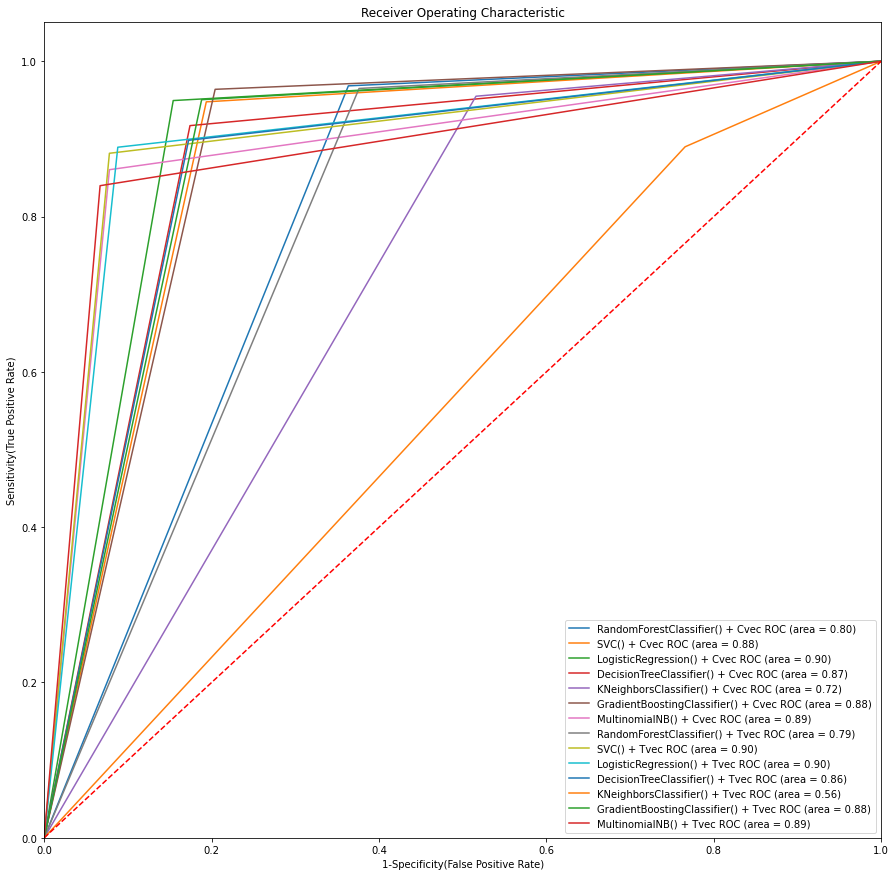

In [27]:
roc_plotter(models, scoring_df)